In [65]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bangla-stopwords/stopwords_bangla.xlsx
/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/train.csv
/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/test.csv


# **Updating/Instaling Libraries**

In [66]:
!pip install keras
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu
!pip install xlrd==1.2.0
!pip install openpyxl

# **Importing Libraries**

In [67]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 


from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.python.keras.models import Sequential

from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


from nltk.corpus import stopwords
import nltk
import re
from nltk.stem import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

# **Loading Dataset**

In [68]:
df_train=pd.read_csv("/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/train.csv")
df_test=pd.read_csv("/kaggle/input/banglamct7-bangla-multiclass-text-dataset-7-tags/BanglaMCT7/test.csv")


In [69]:

df_train['count'] = df_train['cleanText'].str.split().str.len()
df_test['count'] = df_test['cleanText'].str.split().str.len()
display(df_train)
df_train.head()
df_train.describe()
df_train.info()
print(df_train.category.unique())

,category,text,cleanText,count
0,economy,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা (ডব্লিউট...,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সং...,293
1,sports,ইউরোপিয়ান ফুটবলে আজ ঝড় বয়ে যাচ্ছে। একদিকে সংবা...,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবা...,206
2,international,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ থেকে শুরু...,বিজেপির নেতৃত্বে ভারতের উত্তর প্...,167
3,state,নারায়ণগঞ্জের সোনারগাঁ উপজেলার একটি সরকারি প্র...,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকা...,181
4,sports,"‘ছাই থেকে ছাই, ধুলো থেকে ধুলো...’ আধ্যাত্মিক ক...",ছাই ছাই ধুলো ধুলো আধ্যাত্মিক ...,148
...,...,...,...,...
98878,education,সহকারী অধ্যাপক টিচার্স ট্রেনিং কলেজ (মহিলা)...,সহকারী অধ্যাপক টিচার্স ট্রেনিং ক...,389
98879,entertainment,অক্টোবরের ১১ তারিখে ৭৫ বছর পূর্ণ করবেন অমিতাভ ...,অক্টোবরের তারিখে বছর পূর্ণ অমিতা...,147
98880,technology,কাজী নাঈম আল রশিদ। সফটওয়্যার প্রকৌশলী। কাজ করে...,কাজী নাঈম রশিদ সফটওয়্যার প্রকৌশল...,673
98881,technology,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ভেরাইজন কিনে...,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ...,161


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98883 entries, 0 to 98882
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   98883 non-null  object
 1   text       98883 non-null  object
 2   cleanText  98883 non-null  object
 3   count      98883 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.0+ MB
['economy' 'sports' 'international' 'state' 'technology' 'entertainment'
 'education']


In [70]:
display(df_test)
df_test.head()
df_test.describe()
df_test.info()

,category,text,cleanText,count
0,education,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...,260
1,sports,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...,131
2,international,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...,75
3,international,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...,49
4,technology,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...,172
...,...,...,...,...
98879,sports,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয়...,14
98880,entertainment,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার প্রথম অ্যালবাম রঙম...,163
98881,international,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের হাজার ব্যবহারকারীর তথ্য ...,159
98882,economy,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল ...,14


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98884 entries, 0 to 98883
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   98884 non-null  object
 1   text       98884 non-null  object
 2   cleanText  98884 non-null  object
 3   count      98884 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


# **Stopwords Removal**

In [71]:
def stopwordRemoval(text):    
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]
    
    out=' '.join(stm)
    
    return str(out)

In [72]:
data1 =pd.read_excel('/kaggle/input/bangla-stopwords/stopwords_bangla.xlsx')
display(data1)
stop = data1['words'].tolist()

,Unnamed: 0,words
0,0,অই
1,1,অগত্যা
2,2,অত: পর
3,3,অতএব
4,4,অথচ
...,...,...
727,727,হয়েই
728,728,হয়েছিল
729,729,হয়েছে
730,730,হয়েছেন


In [73]:
#df_train['cleanText'] = df_train.cleanText.apply(lambda x: stopwordRemoval(str(x)))


In [74]:
#df_test['cleanText'] = df_test.cleanText.apply(lambda x: stopwordRemoval(str(x)))

# **Stemming**

In [75]:
#make sure to turn on internet on your kernel
#importing stemmer
!pip install bangla-stemmer
from bangla_stemmer.stemmer import stemmer
## stemmer function
def stem_text (x):
  stmr = stemmer.BanglaStemmer()
  words=x.split(' ')
  stm = stmr.stem(words)
  words=(' ').join(stm)
  return words

In [76]:
#df_train['cleanText']=df_train['cleanText'].apply(stem_text)
#df_test['cleanText']=df_test['cleanText'].apply(stem_text)

# **Changing Labels to Numbers**

In [77]:
#['economy' 'sports' 'international' 'state' 'technology' 'entertainment' 'education']

df_train["category"].replace({"economy": "0", "sports": "1","international": "2","state": "3","technology": "4","entertainment": "5","education": "6"}, inplace=True)
df_test["category"].replace({"economy": "0", "sports": "1","international": "2","state": "3","technology": "4","entertainment": "5","education": "6"}, inplace=True)
display(df_train)
display(df_test)

,category,text,cleanText,count
0,0,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা (ডব্লিউট...,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সং...,293
1,1,ইউরোপিয়ান ফুটবলে আজ ঝড় বয়ে যাচ্ছে। একদিকে সংবা...,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবা...,206
2,2,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ থেকে শুরু...,বিজেপির নেতৃত্বে ভারতের উত্তর প্...,167
3,3,নারায়ণগঞ্জের সোনারগাঁ উপজেলার একটি সরকারি প্র...,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকা...,181
4,1,"‘ছাই থেকে ছাই, ধুলো থেকে ধুলো...’ আধ্যাত্মিক ক...",ছাই ছাই ধুলো ধুলো আধ্যাত্মিক ...,148
...,...,...,...,...
98878,6,সহকারী অধ্যাপক টিচার্স ট্রেনিং কলেজ (মহিলা)...,সহকারী অধ্যাপক টিচার্স ট্রেনিং ক...,389
98879,5,অক্টোবরের ১১ তারিখে ৭৫ বছর পূর্ণ করবেন অমিতাভ ...,অক্টোবরের তারিখে বছর পূর্ণ অমিতা...,147
98880,4,কাজী নাঈম আল রশিদ। সফটওয়্যার প্রকৌশলী। কাজ করে...,কাজী নাঈম রশিদ সফটওয়্যার প্রকৌশল...,673
98881,4,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ভেরাইজন কিনে...,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ...,161


,category,text,cleanText,count
0,6,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...,260
1,1,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...,131
2,2,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...,75
3,2,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...,49
4,4,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...,172
...,...,...,...,...
98879,1,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয়...,14
98880,5,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার প্রথম অ্যালবাম রঙম...,163
98881,2,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের হাজার ব্যবহারকারীর তথ্য ...,159
98882,0,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল ...,14


# **Removing Null values**

In [78]:
#display non-null values
df_train = df_train.dropna()
df_test = df_test.dropna()

# **Removing Small Texts**

In [79]:
#counting text length
df_train['count'] = df_train['cleanText'].str.split().str.len()
df_test['count'] = df_test['cleanText'].str.split().str.len()
# Remove the text with words less than 5
df_train= df_train.loc[df_train['count']>10]
df_test= df_test.loc[df_test['count']>10]

# **Shuffle Dataset**

In [80]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
display(df_train)
display(df_test)

,category,text,cleanText,count
0,0,২০১৭-১৮ অর্থবছরের বাজেটের সবচেয়ে আলোচ্য বিষয় ছ...,অর্থবছরের বাজেটের সবচেয়ে আলোচ্য ...,221
1,2,প্রায়ই গলফ খেলার জন্য সমালোচনার মুখে পড়ছেন মা...,প্রায়ই গলফ খেলার সমালোচনার মুখে...,188
2,3,সিলেট নগরের টিলাগড়ে ছাত্রলীগের অন্তর্দ্বন্দ্বে...,সিলেট নগরের টিলাগড়ে ছাত্রলীগের অ...,215
3,3,রাজশাহীতে সম্প্রতি ঘটে যাওয়া হত্যাকাণ্ড এবং সা...,রাজশাহীতে ঘটে হত্যাকাণ্ড সার্বিক ...,217
4,3,ঝালকাঠির নলছিটি উপজেলার কামদেবপুরের খাদেমুল ইস...,ঝালকাঠির নলছিটি উপজেলার কামদেবপুরের...,185
...,...,...,...,...
98282,1,ট্যুর ডি বাংলাদেশের অষ্টম দিন ছিল আজ। কুমিল্লা...,ট্যুর বাংলাদেশের অষ্টম দিন কুমিল...,51
98283,4,চাঁদের দক্ষিণ মেরু অন্ধকারাচ্ছন্ন একটি অঞ্চল। ...,চাঁদের দক্ষিণ মেরু অন্ধকারাচ্ছন্ন ...,195
98284,5,"‘চুল আরও ছোট করেন, যেন মুঠোয় ধরা না যায়!’ ভাইর...",চুল ছোট মুঠোয় ভাইরাল ভিডিও চি...,173
98285,3,জামিনে ছাড়া পাওয়ার পর কারাফটক থেকে আবারও আটক ক...,জামিনে পাওয়ার কারাফটক আবারও আটক ...,80


,category,text,cleanText,count
0,6,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...,260
1,1,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...,131
2,2,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...,75
3,2,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...,49
4,4,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...,172
...,...,...,...,...
98879,1,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয়...,14
98880,5,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার প্রথম অ্যালবাম রঙম...,163
98881,2,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের হাজার ব্যবহারকারীর তথ্য ...,159
98882,0,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল ...,14


In [81]:
train_sentences=df_train['cleanText'].values
train_labels=df_train['category'].values

In [82]:
test_sentences=df_test['cleanText'].values
test_labels=df_test['category'].values

In [83]:
print("Training Set Length: "+str(len(df_train)))
print("Testing Set Length: "+str(len(df_test)))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))

Training Set Length: 98287
Testing Set Length: 98279
train_labels shape: (98287,)
test_labels shape: (98279,)


# **Train/Test/Validation Set**
**This dataset contains two csv files. One is Train set and another is Test set.IN EDA,we have seen that train and test set is equal sized and distribution of class is identical to both of the test and train set.
I have used full train set for training and used 20% of the data from testset for validation set and 80% for testing
The validation set and the Test set is partitioned into stratified fashion to keep the distribution of class intact.**

In [84]:
test_sentences, validation_sentences,test_labels, validation_labels = train_test_split(test_sentences, test_labels,stratify=test_labels,test_size=0.2)

In [85]:
train_labels=keras.utils.to_categorical(train_labels)
test_labels=keras.utils.to_categorical(test_labels)
validation_labels=keras.utils.to_categorical(validation_labels)


print("Training Set Length: "+str(len(df_train)))
print("Testing Set Length: "+str(len(df_test)))
print("training_sentences shape: "+str(train_sentences.shape))
print("testing_sentences shape: "+str(test_sentences.shape))
print("validation_sentences shape: "+str(validation_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))
print("validation_labels shape: "+str(validation_labels.shape))

Training Set Length: 98287
Testing Set Length: 98279
training_sentences shape: (98287,)
testing_sentences shape: (78623,)
validation_sentences shape: (19656,)
train_labels shape: (98287, 7)
test_labels shape: (78623, 7)
validation_labels shape: (19656, 7)


In [86]:
print(train_sentences[1])
print(train_labels[0])

  প্রায়ই    গলফ    খেলার    সমালোচনার    মুখে    পড়ছেন    মার্কিন    প্রেসিডেন্ট    ডোনাল্ড    ট্রাম্প    পূর্বসূরি    বারাক    ওবামাও    অতিরিক্ত    মাত্রায়    গলফ    খেলেছেন    ট্রাম্পের    তুলনায়    ওবামাকে    এতটা    সমালোচনাও    সহ্য    যুক্তরাষ্ট্রের    যেকোনো    ধরনের    উসকানির    প্রতিক্রিয়ায়    নির্দয়    সামরিক    হামলা    চালানো    শুক্রবার    হুমকি    উত্তর    কোরিয়া    আজও    কিনা    ফ্লোরিডায়    ব্যক্তিগত    ক্লাবে    গলফ    খেলতে    গেলেন    প্রেসিডেন্ট    ট্রাম্প    সিএনএনের    প্রতিবেদনে    জানুয়ারি    ক্ষমতা    ট্রাম্পের    গলফ    খেলতে    বাবদ    খরচ    আনুমানিক    দুই    কোটি    ডলার    ইতিমধ্যেই    গলফ    খেলতে    দিন    ব্যয়    ট্রাম্পের    পূর্বসূরি    ওবামা    ক্ষমতায়    থাকার    মেয়াদে    দিন    গলফ    সফরে    বের    ডোনাল্ড    ট্রাম্প    হারে    গলফ    সফরে    বের    হচ্ছেন    বারাক    ওবামাকে    ছাড়িয়ে    যাবেন    বলেই    ধারণা    শুক্রবার    উত্তর    কোরিয়ার    উপপ্রধানমন্ত্রী    হান    রিয়ল    বার্তা    সংস্থা    এপিকে    ট্রাম্প    সময়ই    আক্রমণাত্মক    

In [87]:
vocab_size = 100000
embedding_dim = 64
max_length = 200
trunc_type='post'
oov_tok = "<OOV>"

# **Tokenization**

In [88]:
vocab_size = 100000
embedding_dim = 64
max_length = 200
trunc_type='post'
oov_tok = "<OOV>"


print(train_sentences.shape)
print(train_labels.shape)

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

#464246 words in raw dataset
#463651 words in raw dataset after stopwords removal
#***** after stemming 

print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

(98287,)
(98287, 7)
464161
Word index length:464161


# **After Tokenization Data visualization**

In [89]:
print("Sentence :--> \n")
print(train_sentences[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

  সিলেট    নগরের    টিলাগড়ে    ছাত্রলীগের    অন্তর্দ্বন্দ্বে    নিহত    ওমর    মিয়াদের    হত্যাকারীদের    গ্রেপ্তারের    দাবিতে    মাথায়    কাফনসদৃশ    কাপড়    বেঁধে    বিক্ষোভ    ছাত্রলীগের    একাংশ    মঙ্গলবার    দুপুরে    সিলেট    ওসমানী    মেডিকেল    কলেজ    হাসপাতালে    মিয়াদের    মরদেহের    ময়নাতদন্ত    শেষে    পুলিশ    পরিবারের    লাশ    হস্তান্তর    সময়    একদফা    লাশ    বিক্ষোভ    মিছিল    নগরের    কেন্দ্রস্থলের    চৌহাট্টা    পয়েন্টে    মাথায়    কাফনসদৃশ    সাদা    কাপড়    বেঁধে    অবস্থান    নেন    ছাত্রলীগের    নেতা    কর্মীরা    সময়    ঘটনার    নেপথ্যে    ছাত্রলীগ    আওয়ামী    লীগের    দুই    নেতার    বিরুদ্ধে    স্লোগান    শোনা    গতকাল    সোমবার    বেলা    তিনটায়    টিলাগড়ে    ছাত্রলীগের    পক্ষের    ছুরিকাঘাতে    ওমর    মিয়াদ    নিহত    ছুরিকাহত    আহত    আরেক    কর্মী    ওমর    মিয়াদ    লিডিং    ইউনিভার্সিটির    আইন    বিভাগের    ছাত্র    টিলাগড়ে    জেলা    ছাত্রলীগের    সাবেক    সভাপতি    হিরণ    মাহমুদের    পক্ষের    কর্মী    বিক্ষোভে    জেলা    

In [90]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (98287, 200)
Padded shape(testing): (78623, 200)


# **Model Creation**

**All hyperparameters are optimized**

In [91]:
from tensorflow.python.keras.optimizer_v2.adam import Adam
model= Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(16, return_sequences=True)))
#l2 regularizer
model.add(Dense(16,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
model.add(Flatten())
model.add(Dense(7, activation='softmax'))
#sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 64)           6400000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 32)           10368     
_________________________________________________________________
dense_4 (Dense)              (None, 200, 16)           528       
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 22407     
Total params: 6,433,303
Trainable params: 6,433,303
Non-trainable params: 0
_________________________________________________________________


In [92]:
history=model.fit(padded,train_labels,epochs=4,batch_size=512,validation_data=( validation_padded,validation_labels),use_multiprocessing=True, workers=8)

Epoch 1/4
192/192 [==============================] - 197s 1s/step - loss: 1.0572 - accuracy: 0.6784 - val_loss: 0.3954 - val_accuracy: 0.9218
Epoch 2/4
192/192 [==============================] - 190s 989ms/step - loss: 0.2851 - accuracy: 0.9512 - val_loss: 0.3071 - val_accuracy: 0.9364
Epoch 3/4
192/192 [==============================] - 192s 1s/step - loss: 0.1605 - accuracy: 0.9774 - val_loss: 0.3013 - val_accuracy: 0.9312
Epoch 4/4
192/192 [==============================] - 193s 1s/step - loss: 0.0952 - accuracy: 0.9905 - val_loss: 0.3051 - val_accuracy: 0.9324


# **Learning Curve**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


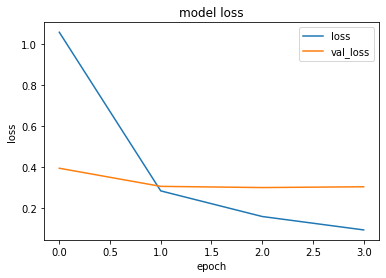

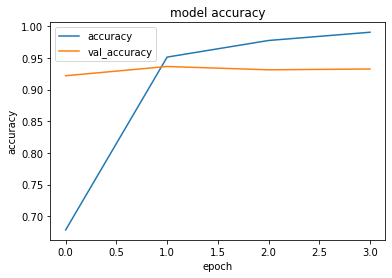

In [93]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()


# **Evaluation**

In [94]:
#accuracy calculation
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=512)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=512)
print("The test accuracy is: "+str(loss_and_metrics[1]))

192/192 [==============================] - 31s 163ms/step - loss: 0.0671 - accuracy: 0.9960
The train accuracy is: 0.9960218667984009
154/154 [==============================] - 26s 166ms/step - loss: 0.3198 - accuracy: 0.9276
The test accuracy is: 0.9275657534599304


In [95]:
predictions = model.predict(testing_padded)

In [96]:
predictions = np.argmax(predictions, axis=-1) 

In [97]:
test_labels=np.argmax(test_labels, axis=-1)

In [98]:
precision, recall, fscore, _ = precision_recall_fscore_support(test_labels,predictions, average='weighted')
print("Precision :"+str(precision))
print("Recall :"+str(recall))
print("fscore :"+str(fscore))

Precision :0.9277653355355727
Recall :0.9275657250422904
fscore :0.9275903205783463


# **Confusion Matrix & Classification Report**

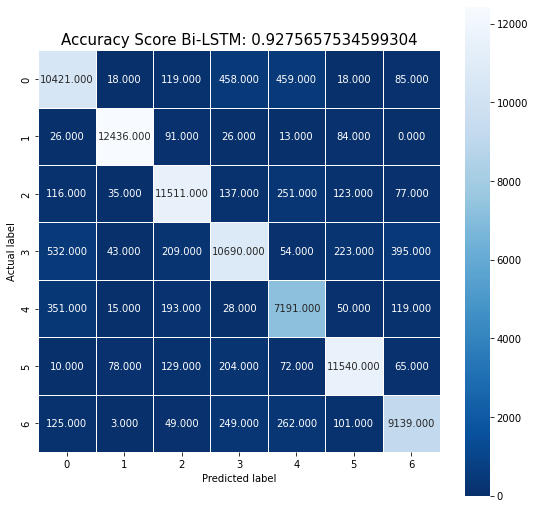

In [99]:
cm = metrics.confusion_matrix(test_labels,predictions)
#print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score Bi-LSTM: {0}'.format(loss_and_metrics[1])
plt.title(all_sample_title, size = 15);


In [100]:
report = pd.DataFrame(classification_report(y_true = test_labels, y_pred = predictions, output_dict=True)).transpose()
report = report.rename(index={'0': 'economy','1':'sports','2':'international','3':'state','4':'technology','5':'entertainment','6':'education'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
display(report)

,precision,recall,f1-score,support
economy,89.98,90.01,90.00,11578.000000
sports,98.48,98.11,98.29,12676.000000
international,93.58,93.97,93.77,12250.000000
state,90.65,88.01,89.31,12146.000000
technology,86.62,90.49,88.51,7947.000000
entertainment,95.07,95.39,95.23,12098.000000
education,92.50,92.05,92.28,9928.000000
accuracy,92.76,92.76,92.76,0.927566
macro avg,92.41,92.57,92.48,78623.000000
weighted avg,92.78,92.76,92.76,78623.000000
